## Analysis of various reconstructions

This notebook loads results from the iterative recovery of structures from invariants, saved as pickles, and creates graphs showing the quality of the reconstructions.

In [1]:
import json
import numpy as np
import pandas

from milad.play import asetools

import qm9_utils

Let's load the datasets we need

In [2]:
from schnetpack import datasets

qm9data = datasets.QM9('data/qm9.db', download=True)
len(qm9data)

133885

In [3]:
with open('data/qm9_subset.json', 'r') as subset:
    test_set = json.load(subset)
test_set = {int(key): value for key, value in test_set.items()}

Analyse the results grouping RMSDs for each size

In [4]:
def get_rmsds(frame: pandas.DataFrame):
    min_size = frame['Size'].min()
    max_size = frame['Size'].max()
    mean_rmsds = []
    for size in range(min_size, max_size + 1):
        subframe = frame.loc[frame['Size'] == size]
                
        min_rmsds = []
        for qm9id in subframe['QM9 ID'].unique():
            min_rmsds.append(subframe.loc[subframe['QM9 ID'] == qm9id]['RMSD'].min())
#         for attempt in subframe['Attempt #'].unique():
#             min_rmsds.extend(subframe.loc[subframe['Attempt #'] == attempt]['RMSD'])
#             min_rmsds.append(subframe.loc[subframe['Attempt #'] == attempt]['RMSD'].min())
        min_rmsds = np.array(min_rmsds)
                                    
        if len(subframe) > 0:
            mean = 10**np.log10(min_rmsds).mean()
            rmsd = mean
            lower_lim = mean - min_rmsds.min()
            upper_lim = min_rmsds.max() - mean
#             lower_lim = mean - subframe['RMSD'].min()
#             upper_lim = subframe['RMSD'].max() - mean
            mean_rmsds.append([size, rmsd, lower_lim, upper_lim])
    
    return np.array(mean_rmsds)


def analyse_by_density(frame: pandas.DataFrame, qm9data):
    results = []
    for idx in frame['QM9 ID'].unique():
        system = qm9data.get_atoms(idx=idx)
        radius = asetools.prepare_molecule(system) # Centre the molecule and find the max radius.
        
        rmsds = frame.loc[frame['QM9 ID'] == idx]['RMSD']
#         mean_rmsd = 10**np.log10(rmsds).mean()
        mean_rmsd = rmsds.min()
        
        lower_lim = mean_rmsd - rmsds.min()
        upper_lim = rmsds.max() - mean_rmsd
        
        num_atoms = len(system)
        density = radius
        
        results.append([density, mean_rmsd, lower_lim, upper_lim, num_atoms])

    return np.array(results)

import matplotlib
import matplotlib.pyplot as plt

matplotlib.style.use('seaborn-whitegrid')

cmap = ('#845ec2',  '#FF9D47', '#ff9671')

def create_recovery_plot(
    *dataset: np.ndarray,
    axes=None,
    xlabel='Num. atoms',
    ylabel: str=None,
    fmt='o',
    wide_error_bars=True,
    cmap=('#845ec2',  '#FF9D47', '#ff9671'),
):
    axes = axes or plt.figure().gca()
        
    axes.set_xlabel(xlabel)
    if ylabel is not None:
        axes.set_ylabel(ylabel)
        
    error_bars = dict(
        fmt=fmt,
#         capsize=4,
    )
    if wide_error_bars:
        error_bars.update(elinewidth=3, capsize=0,)
    
    for i, (data, colour) in enumerate(zip(dataset, cmap)):
        axes.errorbar(
            data[:, 0],
            data[:, 1],
            yerr=data[:, 2:4].T,
            color=f'{colour}AA',
            markeredgecolor='black',
            markeredgewidth=0.5,
            markersize=(7 - 2 * i),
            ecolor=f'{colour}77',
            **error_bars,
        )
    
    return axes

## Analysis of structure recovery from moments

In [5]:
def structure_from_moments_plot(
    no_species, 
    with_species, 
    qm9data,
    legend='upper left',
    threshold=1e-6
):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4), 
                                                 gridspec_kw={'width_ratios': [1, 1, 1]})
    ax1.set_yscale('log')
    ax1.set_ylim([1e-16, 10])
    ax1.set_ylabel("RMSD of $\Phi_i$ vs $\Phi'_i$")

    no_species_rmsds, with_species_rmsds = tuple(map(get_rmsds, (no_species, with_species)))
    create_recovery_plot(
        no_species_rmsds,
        with_species_rmsds,
        axes=ax1
    )

    radius_no_species = analyse_by_density(no_species, qm9data)
    radius_with_species = analyse_by_density(with_species, qm9data)
        
    create_recovery_plot(
        radius_no_species,
        axes=ax2,
        xlabel='Radius of molecule ($\AA$)',
        wide_error_bars=False
    )
    
    successful_no_species = np.sum(radius_no_species[:, 1] < threshold) / len(radius_no_species)
    successful_with_species = np.sum(radius_with_species[:, 1] < threshold) / len(radius_with_species)

    # Lay out and add legend
    fig.tight_layout()
    ax2.legend([f'No species ({successful_no_species:.2f})',
                f'With species ({successful_with_species:.2f})'], loc=legend)
    
    # Add the reconstrction threshold line
    ax2.axhline(y=threshold, xmin=0, xmax=np.max(radius_no_species[:, 0]),
               linestyle='dashed', color='grey', label='threshold')
    
    create_recovery_plot(
        radius_with_species,
        axes=ax3,
        xlabel='Radius of molecule ($\AA$)',
        wide_error_bars=False,
        cmap=cmap[1:]
    )
    
    ax3.legend([f'With species ({successful_with_species:.2f})'], loc=legend)
    
    # Add the reconstrction threshold line
    ax3.axhline(y=threshold, xmin=0, xmax=np.max(radius_no_species[:, 0]),
               linestyle='dashed', color='grey', label='threshold')
    
    return fig

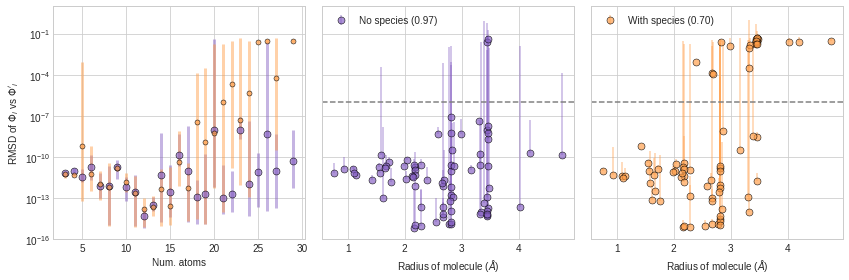

In [6]:
no_species = pandas.read_pickle('structure_recovery_iterative_no_species.pickle')
with_species = pandas.read_pickle('structure_recovery_iterative_with_species.pickle')
fig = structure_from_moments_plot(no_species, with_species, qm9data, legend='upper left')
print()
fig.savefig('img/structure_recovery_iterative.pdf', bbox_inches='tight')

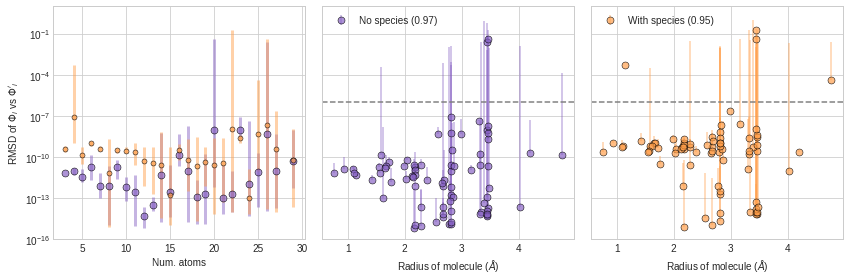

In [7]:
no_species = pandas.read_pickle('structure_recovery_iterative_no_species.pickle')
with_species2 = pandas.read_pickle('species_recovery_from_decoded_positions.pickle')
fig = structure_from_moments_plot(no_species, with_species2, qm9data, legend='upper left')
print()
fig.savefig('img/species_recovery.pdf', bbox_inches='tight')

In [8]:
pg_no_species = qm9_utils.order_by_pointgroup(qm9_utils.get_point_groups(qm9data, test_set, ignore_species=True))
pg_with_species = qm9_utils.order_by_pointgroup(qm9_utils.get_point_groups(qm9data, test_set, ignore_species=False))

In [9]:
def get_proportions(pgs: dict, results):
    proportions = {}
    for pg, ids in pgs.items():
        found = 0
        for qm9id in ids:
            if any(results[results['QM9 ID'] == qm9id]['RMSD'] < 1e-6):
                found += 1
        total = len(ids)
        proportions[pg] = (total, found, found / len(ids))
    return proportions

In [10]:
pg_res_no_species = get_proportions(pg_no_species, no_species)
pg_res_with_species = get_proportions(pg_with_species, with_species)
pg_res_with_species2 = get_proportions(pg_with_species, with_species2)

In [83]:
def create_pg_bar(pg_res: dict, colour):
    fig = plt.figure(figsize=(5, 2))
    ax = fig.gca()
    
    ax.set_ylabel('% correctly inverted')
    
    xvalues = list(sorted(pg_res.keys()))
    labels = []
    for entry in xvalues:
        labels.append(f'${entry[0]}_{entry[1:]}$'.replace('*', '\infty{}'))

    ax.bar(
        list(range(len(xvalues))),
        [pg_res[key][2] for key in xvalues],
        tick_label=labels,
        color=colour,
        ecolor='black',
        alpha=0.8,
    )
    for rect, pg in zip(ax.patches, xvalues):
        height = rect.get_height()
        label = f'{pg_res[pg][1]}/{pg_res[pg][0]}'
        ax.annotate(
            label,
            xy=(rect.get_x() + 0.5 * rect.get_width(), height),
            ha="center", va="bottom",
        )
    
    return fig

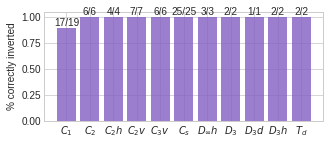

In [84]:
fig = create_pg_bar(pg_res_no_species, colour=cmap[0])
fig.savefig('img/pg_no_species.pdf', bbox_inches='tight')

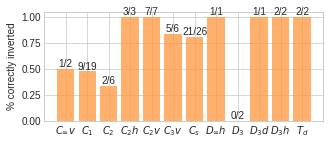

In [85]:
fig = create_pg_bar(pg_res_with_species, colour=cmap[1])
fig.savefig('img/pg_with_species.pdf', bbox_inches='tight')

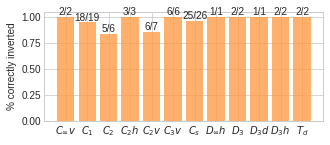

In [86]:
fig = create_pg_bar(pg_res_with_species2, colour=cmap[1])
fig.savefig('img/pg_with_species2.pdf', bbox_inches='tight')